See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [ ]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]


if use_gdrive == 'yes':
  from google.colab import drive
  # Montar Google Drive
  # "comentamos esta celda y añadimos la siguiente" drive.mount('/gdrive')
  drive.mount('/content/drive', force_remount=True)
  # Ruta al archivo ZIP en Google Drive
  # "comentamos esta celda y añadimos la siguiente" root = '/gdrive/My Drive/vision_transformer_colab'
  root = "/content/drive/MyDrive/Colab_Notebooks"
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /content/drive

Changed CWD to "/content/drive/MyDrive/Colab_Notebooks"


In [ ]:
# Clone repository and pull latest changes.
'''![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull'''

In [ ]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#añadido
!pip install opencv-python-headless
!pip install imagehash



#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-w0t2zu01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.0 MB/s eta 0:00:00


### Imports

Los datos que consltan en esta sección provienen de un bucket de Google Cloud Storage. En este caso, las líneas de código con el comando gsutil están accediendo a recursos almacenados en los buckets [gs://vit_models/](https://) y [gs://mixer_models/](https://).

### ¿Qué son estos buckets?
Un bucket es un contenedor en Google Cloud Storage donde se almacenan archivos o datos de manera organizada.

En este caso:

[gs://vit_models/](https://): Almacena modelos preentrenados de Vision Transformer (ViT).
Por ejemplo:
Modelos entrenados en ImageNet (imagenet*).
Modelos SAM (Segment Anything Models).

[gs://mixer_models/](https://): Almacena modelos relacionados con MLP-Mixer, otra arquitectura para visión por computadora.

## Explicación de los comandos:

### !gsutil ls -lh gs://vit_models/imagenet*:
Lista todos los modelos preentrenados de ViT que se entrenaron usando el dataset ImageNet.
Muestra información como tamaño del archivo y la ruta.

### !gsutil ls -lh gs://vit_models/sam:
Lista modelos de SAM disponibles en ese bucket.

### !gsutil ls -lh gs://mixer_models/*:
Lista los modelos de MLP-Mixer disponibles.

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

In [ ]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')
#Se incluyen estas lineas para explicar y corregir el error
#¿Por qué aparece "No TPU detected"?
#Esto ocurre porque el entorno de ejecución actual no tiene configurado el uso de un TPU. Probablemente estás ejecutando el Colab en un entorno estándar (CPU o GPU).
#Para activar un TPU en Google Colab se debe cambiar el tipo de entorno de ejecución:
#En el menú superior de Colab:
#Ve a "Runtime" > "Change runtime type".
#En "Hardware accelerator", selecciona TPU. Haz clic en "Save" y reinicia el entorno
#Después de cambiar a TPU, Colab asignará un TPU y configurará la variable de entorno COLAB_TPU_ADDR.

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [ ]:
!echo $COLAB_TPU_ADDR

In [ ]:
import os
print(os.environ.get('COLAB_TPU_ADDR'))


None


In [ ]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[CudaDevice(id=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.

# Si ejecutas este código en un Colab, verás los archivos abiertos en la parte derecha. Desde allí puedes:
# Leer el contenido de los archivos para entender cómo está estructurado el proyecto.
# Realizar ediciones rápidas en el código.
# Guardar los cambios en tu sesión de Colab o descargar los archivos modificados.

from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

INFO:absl:Created `ArrayHandler` with primary_host=0, replica_id=0


In [ ]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [ ]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [ ]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

'''For The error message FailedPreconditionError:
ioctl failed; [0000:00:04.0 PE0 C0 MC-1 TN0] Failed to set number of simple DMA addresses
PLEASE SET THE TPU TO GPU IS AN RESOURCE AVAILABILITY ERROR
'''

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmp3pvsf0zktfds
INFO:absl:For 'cifar10/3.0.2': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cifar10/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.1a523cfeec7742a9abdc500db4fe72a6...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HPKGIW_3.0.2/cifar10-train.tfrecord*...:   0%|         …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.HPKGIW_3.0.2/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.HPKGIW_3.0.2/cifar10-test.tfrecord*...:   0%|          …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.HPKGIW_3.0.2/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


'For The error message FailedPreconditionError:\nioctl failed; [0000:00:04.0 PE0 C0 MC-1 TN0] Failed to set number of simple DMA addresses\nPLEASE SET THE TPU TO GPU IS AN RESOURCE AVAILABILITY ERROR\n'

In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

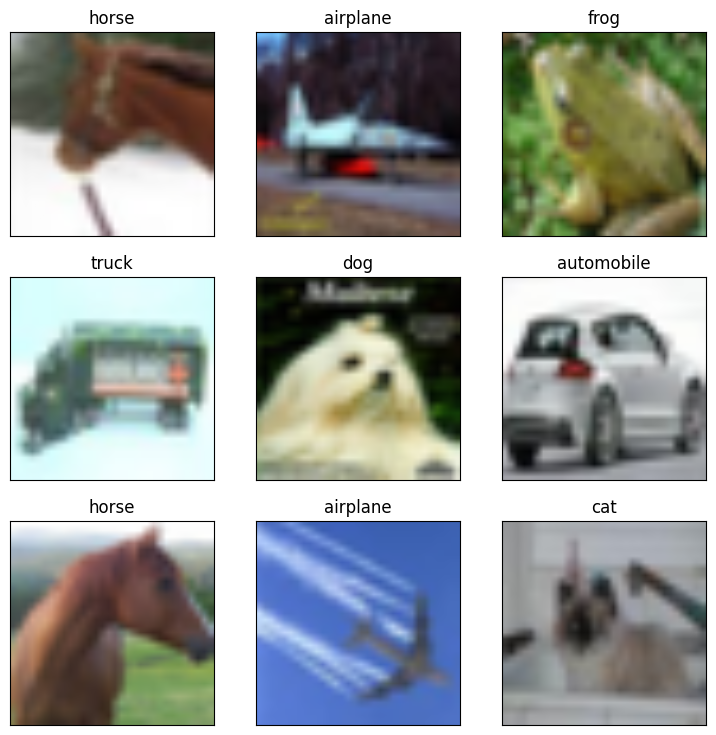

In [ ]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

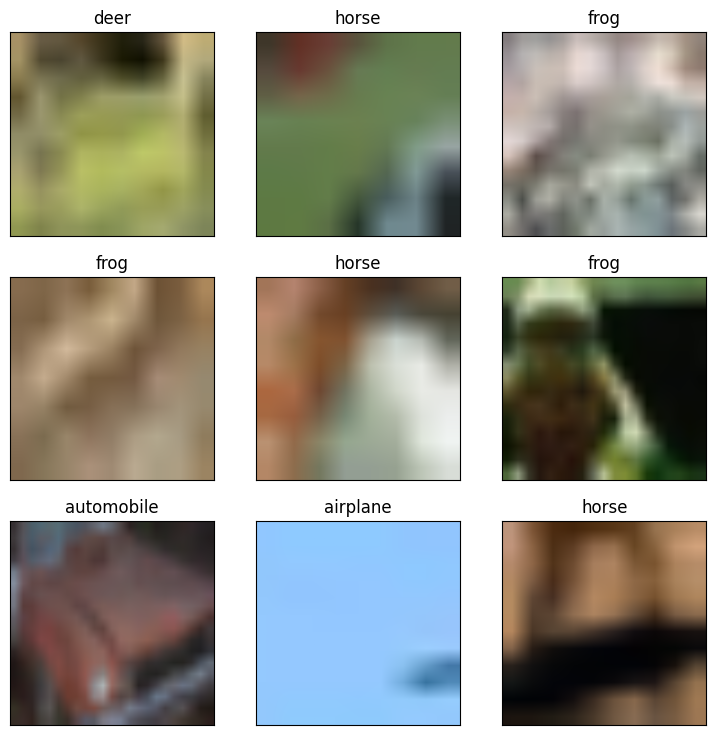

In [ ]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [ ]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:37<00:00,  1.98s/it]


Array(0.10063734, dtype=float32)

### Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 20 #100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


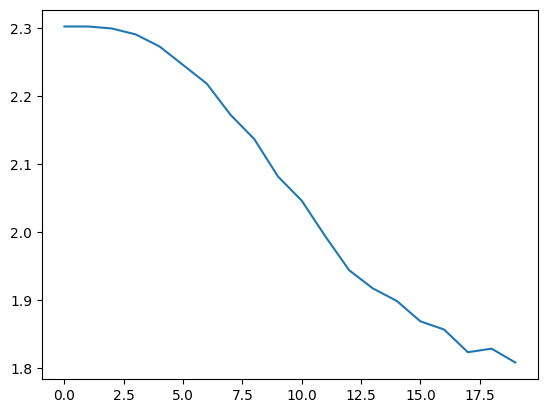

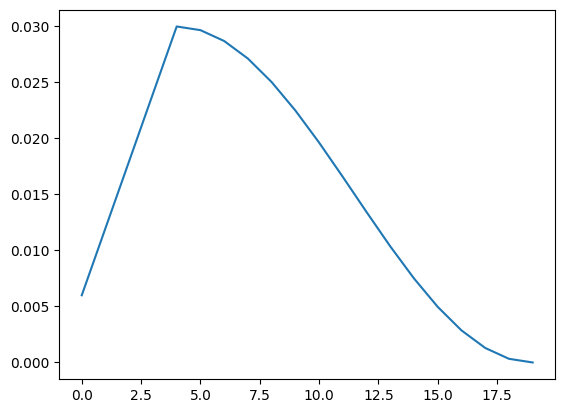

In [ ]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:27<00:00,  1.44s/it]


Array(0.92547286, dtype=float32)

### Inference

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

In [ ]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2025-01-21 20:21:37--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.2’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.009s  

2025-01-21 20:21:38 (2.40 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.2’ saved [21675/21675]



--2025-01-21 20:21:43--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.4.30, 104.26.5.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/1065/384/384.jpg?hmac=4jjQwzqwRRII7iDTOluPgR0OyCUlM1N-7L3b8V4Gtfc [following]
--2025-01-21 20:21:44--  https://fastly.picsum.photos/id/1065/384/384.jpg?hmac=4jjQwzqwRRII7iDTOluPgR0OyCUlM1N-7L3b8V4Gtfc
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18036 (18K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  17.61K  --.-KB/s    in 0.001s  

2025-01-21 20:21:45 (15.8 MB/s) - ‘picsum.jpg’ saved [18036/18036]



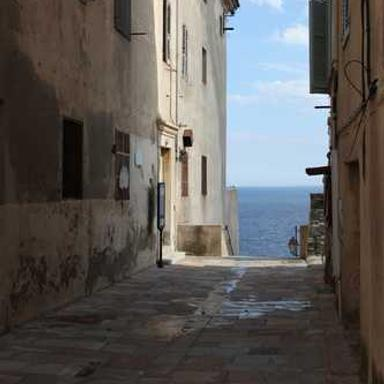

In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.55808 : monastery
0.05396 : patio, terrace
0.05360 : palace
0.04763 : prison, prison_house
0.02868 : bell_cote, bell_cot
0.02652 : seashore, coast, seacoast, sea-coast
0.02204 : lakeside, lakeshore
0.01843 : castle
0.01280 : promontory, headland, head, foreland
0.00774 : restaurant, eating_house, eating_place, eatery


In [ ]:
import cv2
import os

def is_blurry(image_path, threshold=100):
    """
    Detecta si una imagen está borrosa usando el método Laplaciano.

    Parámetros:
        image_path (str): Ruta a la imagen.
        threshold (float): Umbral de varianza. Imágenes con varianza menor son consideradas borrosas.

    Retorna:
        bool: True si la imagen está borrosa, False si no lo está.
        float: Varianza del Laplaciano.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"La imagen {image_path} no existe.")

    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"No se pudo leer la imagen {image_path}.")

    # Aplicar el filtro Laplaciano y calcular su varianza
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

    # Retornar si está borrosa según el umbral
    return laplacian_var < threshold, laplacian_var

def detect_blurry_images_in_directory(directory, threshold=100):
    """
    Detecta imágenes borrosas en un directorio.

    Parámetros:
        directory (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Retorna:
        List[Tuple[str, float, bool]]: Lista con la ruta, varianza y estado (borrosa o no) de cada imagen.
    """
    results = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        if os.path.isfile(image_path):
            try:
                is_blurred, variance = is_blurry(image_path, threshold)
                results.append((filename, variance, is_blurred))
            except Exception as e:
                print(f"Error procesando {filename}: {e}")
    return results


In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)
np.savez_compressed("cifar10_images.npz", images=[img.numpy() for img, _ in dataset['train']])


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split None, from /root/tensorflow_datasets/cifar10/3.0.2



Resumen del análisis:
Total de imágenes analizadas: 10000
Total de imágenes borrosas detectadas: 56
Imágenes nítidas: 9944


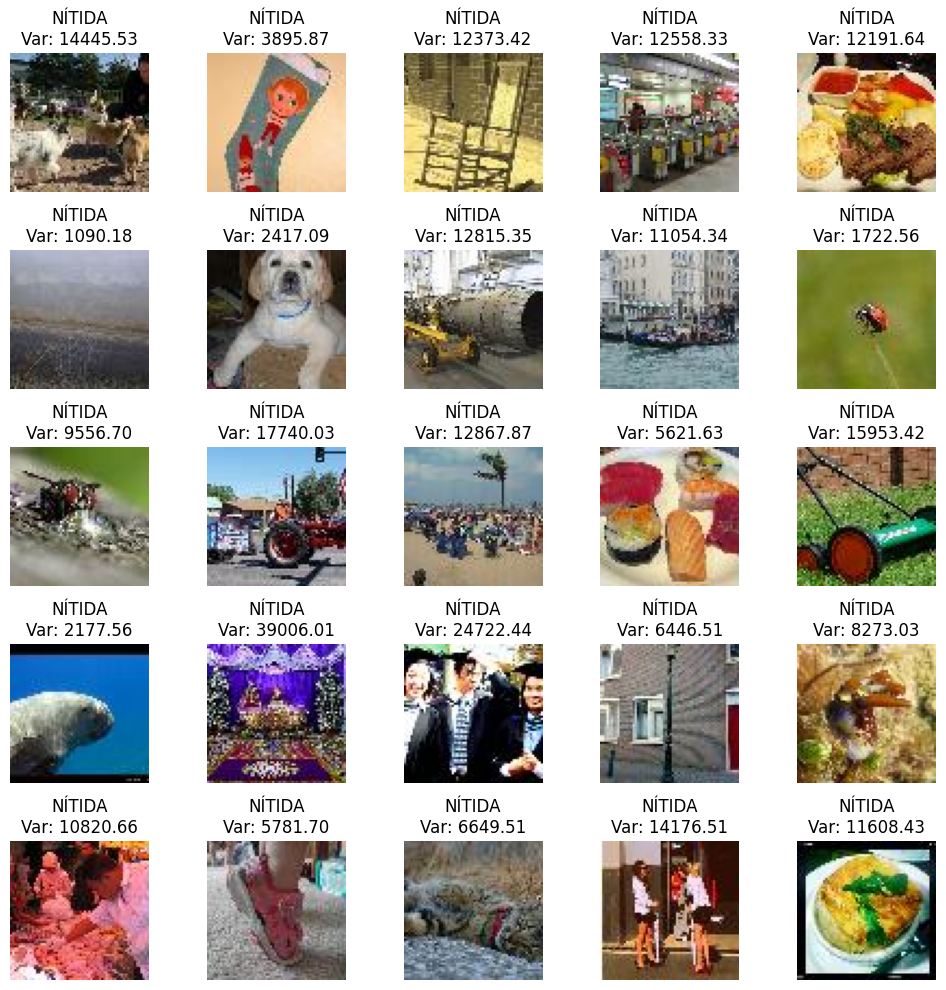

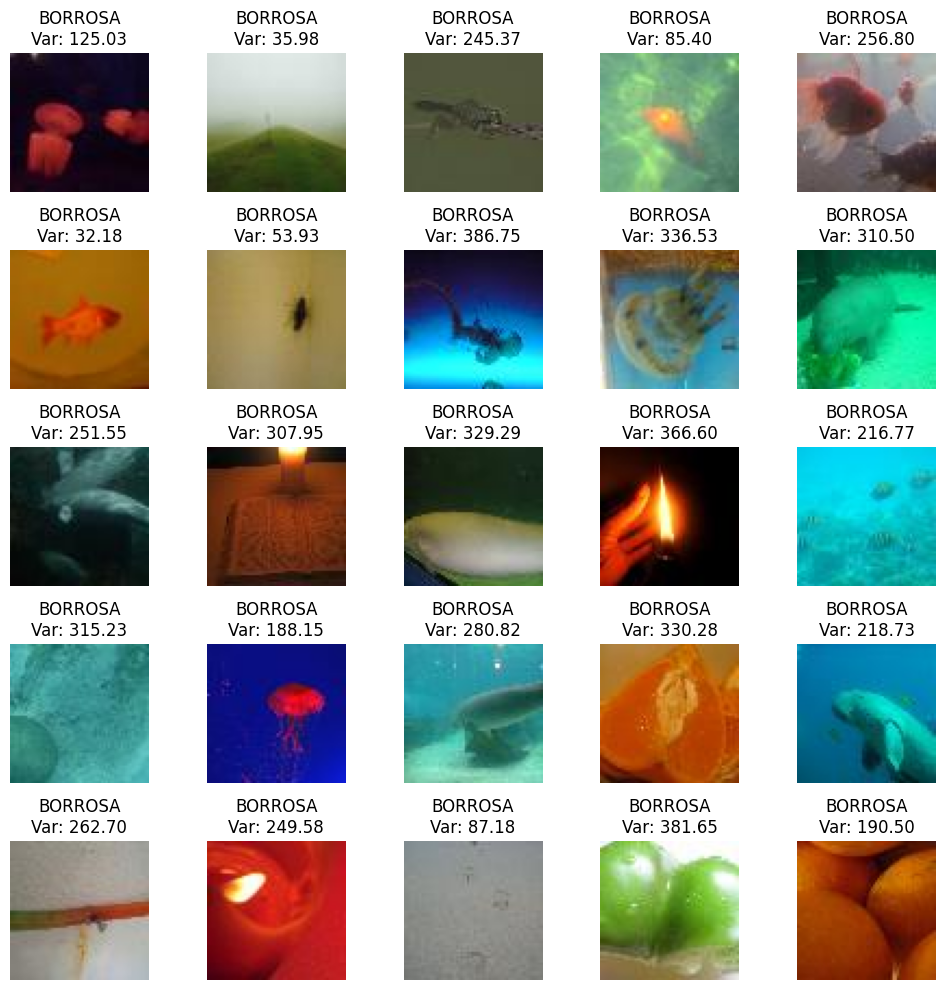

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Función para detectar imágenes borrosas en un directorio
def detect_blurry_images_in_directory(directory_path, threshold=400):
    """
    Detecta imágenes borrosas en un directorio.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Returns:
        List[Tuple[str, float, bool]]: Nombre del archivo, varianza y estado (borrosa o no).
    """
    results = []
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):  # Verificar si es un archivo
            # Cargar la imagen
            img = cv2.imread(image_path)
            if img is None:
                print(f"No se pudo leer la imagen: {filename}")
                continue

            # Convertir a escala de grises
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Aplicar filtro Laplaciano
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            is_blurred = laplacian_var < threshold
            results.append((filename, laplacian_var, is_blurred))
    return results

# 2. Mostrar una imagen con Matplotlib
def show_image(image_path, title):
    """
    Muestra una imagen con Matplotlib.

    Args:
        image_path (str): Ruta de la imagen.
        title (str): Título para mostrar en la gráfica.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 3. Mostrar imágenes en formato grid
def show_img_grid(images, titles, grid_size=(3, 3), figsize=(10, 10)):
    """
    Muestra las imágenes en una cuadrícula.

    Args:
        images (list): Lista de rutas de imágenes.
        titles (list): Lista de títulos para cada imagen.
        grid_size (tuple): Tamaño de la cuadrícula (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.ravel()
    for idx, (img_path, title) in enumerate(zip(images, titles)):
        if idx >= len(axes):
            break
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(title)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# 4. Aplicación principal: Analizar un directorio de imágenes
def analyze_blurry_images_in_directory(directory_path, threshold=400, grid_size=(3, 3)):
    """
    Analiza las imágenes en un directorio para detectar imágenes borrosas y mostrarlas en un grid.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.
        grid_size (tuple): Tamaño de la cuadrícula para mostrar imágenes.

    Returns:
        None
    """
    # Detectar imágenes borrosas
    blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        # Informe general
    print(f"\nResumen del análisis:")
    print(f"Total de imágenes analizadas: {len(blurry_results)}")
    print(f"Total de imágenes borrosas detectadas: {num_b_blurry}")
    print(f"Imágenes nítidas: {len(blurry_results) - num_b_blurry}")

    # Preparar imágenes para el grid
    selected_images = []
    titles = []
    for filename, var, blurred in blurry_results[:grid_size[0] * grid_size[1]]:
        image_path = os.path.join(directory_path, filename)
        selected_images.append(image_path)
        status = "BORROSA" if blurred else "NÍTIDA"
        titles.append(f"{status}\nVar: {var:.2f}")

    # Mostrar imágenes en formato grid
    show_img_grid(selected_images, titles, grid_size)

    # Preparar imágenes borrosas para el grid
    selected_images = []
    titles = []
    for filename, var, blurred in blurry_results:
        if blurred:  # Solo incluir imágenes borrosas
            image_path = os.path.join(directory_path, filename)
            selected_images.append(image_path)
            titles.append(f"BORROSA\nVar: {var:.2f}")

            # Detener si se alcanza el límite del grid
            if len(selected_images) >= grid_size[0] * grid_size[1]:
                break

    # Mostrar imágenes borrosas en formato grid
    if selected_images:
        show_img_grid(selected_images, titles, grid_size)
    else:
        print("No se encontraron imágenes borrosas para mostrar.")


# 5. Ejecutar el análisis en un directorio
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200-64x64/test/images"  # Ruta al directorio de imágenes
threshold = 400  # Ajusta el umbral según sea necesario
analyze_blurry_images_in_directory(directory_path, threshold, grid_size=(5, 5))

Claves disponibles en cifar10_images.npz: ['images']
Total de imágenes analizadas: 50000
Total de imágenes borrosas detectadas: 660
Imágenes nítidas: 49340


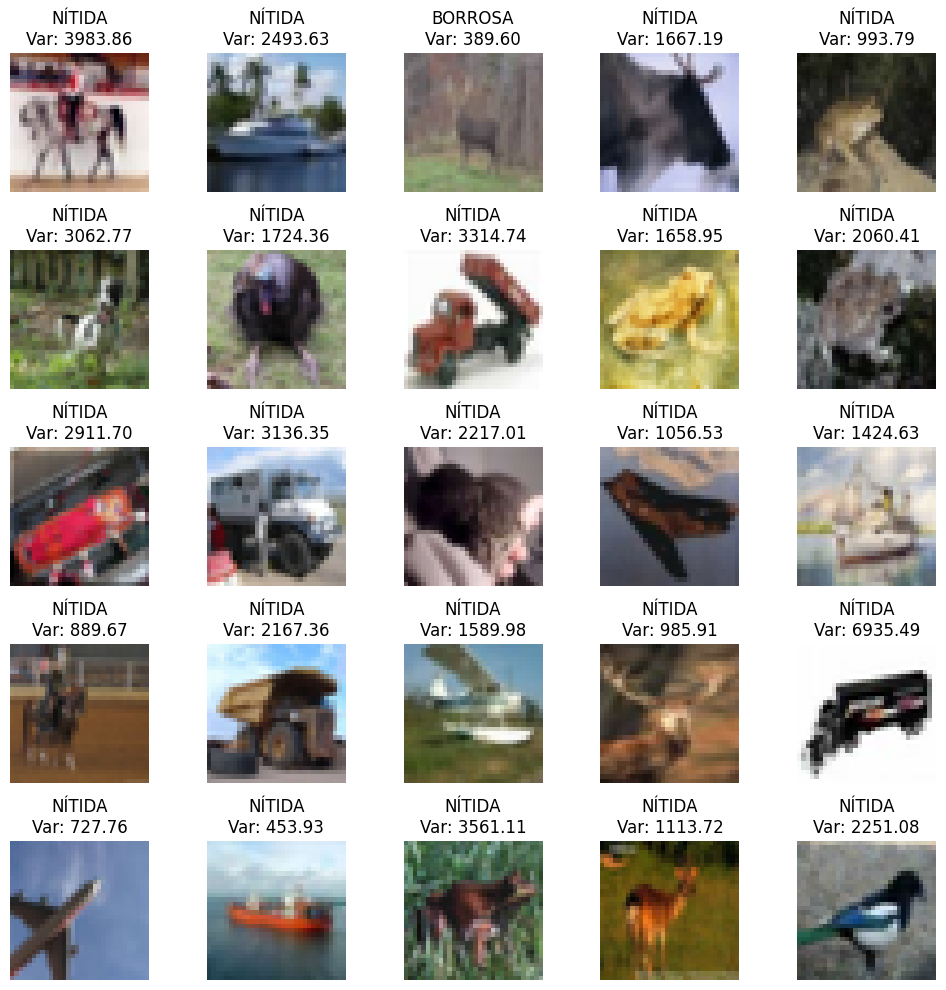

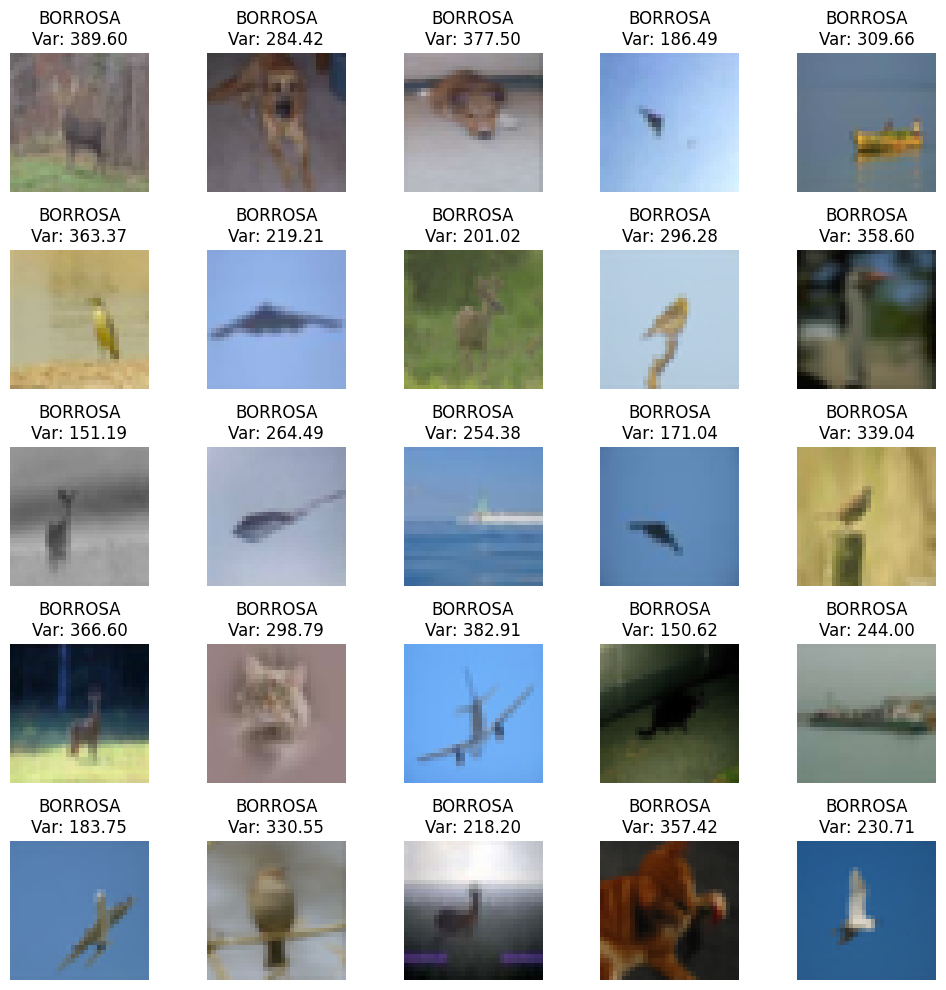

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Función para cargar un archivo .npz
def load_npz_file(file_path):
    """
    Carga un archivo .npz y devuelve su contenido.

    Args:
        file_path (str): Ruta al archivo .npz.

    Returns:
        dict: Diccionario con los datos almacenados en el archivo.
    """
    data = np.load(file_path, allow_pickle=True)
    print(f"Claves disponibles en {file_path}: {list(data.keys())}")
    return data

# 2. Función para detectar imágenes borrosas
def detect_blurry_images_from_npz(images, threshold=400):
    """
    Detecta imágenes borrosas en un array NumPy.

    Args:
        images (np.array): Array de imágenes.
        threshold (float): Umbral de varianza para determinar si está borrosa.

    Returns:
        List[Tuple[int, float, bool]]: Índice, varianza y estado (borrosa o no).
    """
    results = []
    for i, img in enumerate(images):
        # Convertir imagen a escala de grises si tiene 3 canales
        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img

        # Aplicar filtro Laplaciano
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        is_blurred = laplacian_var < threshold
        results.append((i, laplacian_var, is_blurred))
    return results

# 3. Función para mostrar una imagen con Matplotlib
def show_image(image, title):
    """
    Muestra una imagen con Matplotlib.

    Args:
        image (np.array): Imagen en formato NumPy.
        title (str): Título para mostrar en la gráfica.
    """
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 4. Función para mostrar imágenes en formato grid
def show_img_grid(images, titles, grid_size=(3, 3), figsize=(10, 10)):
    """
    Muestra las imágenes en una cuadrícula.

    Args:
        images (list): Lista o array de imágenes.
        titles (list): Lista de títulos para cada imagen.
        grid_size (tuple): Tamaño de la cuadrícula (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.ravel()
    for idx, (img, title) in enumerate(zip(images, titles)):
        if idx >= len(axes):
            break
        axes[idx].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[idx].set_title(title)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# 5. Análisis principal con integración de grid
def analyze_blurry_images(npz_file_path, image_key, threshold=400, grid_size=(3, 3)):
    """
    Analiza las imágenes en un archivo .npz para detectar imágenes borrosas y las muestra en un grid.

    Args:
        npz_file_path (str): Ruta al archivo .npz.
        image_key (str): Clave para acceder a las imágenes en el archivo.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.
        grid_size (tuple): Tamaño de la cuadrícula para mostrar imágenes.

    Returns:
        None
    """
    # Cargar datos del archivo .npz
    data = load_npz_file(npz_file_path)

    # Obtener las imágenes
    if image_key not in data:
        print(f"Clave '{image_key}' no encontrada en el archivo.")
        return
    images = data[image_key]

    # Detectar imágenes borrosas
    blurry_results = detect_blurry_images_from_npz(images, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
    print(f"Total de imágenes analizadas: {len(images)}")
    print(f"Total de imágenes borrosas detectadas: {num_b_blurry}")
    print(f"Imágenes nítidas: {len(images) - num_b_blurry}")

    # Preparar imágenes para el grid
    selected_images = []
    titles = []
    for idx, var, blurred in blurry_results[:grid_size[0] * grid_size[1]]:
        selected_images.append(images[idx])
        status = "BORROSA" if blurred else "NÍTIDA"
        titles.append(f"{status}\nVar: {var:.2f}")

    # Mostrar imágenes en formato grid
    show_img_grid(selected_images, titles, grid_size)

    # Preparar imágenes borrosas para el grid
    selected_images = []
    titles = []
    for idx, var, blurred in blurry_results:
        if blurred:  # Solo incluir imágenes borrosas
            selected_images.append(images[idx])
            titles.append(f"BORROSA\nVar: {var:.2f}")

            # Detener si se alcanza el límite del grid
            if len(selected_images) >= grid_size[0] * grid_size[1]:
                break

    # Mostrar imágenes borrosas en formato grid
    if selected_images:
        show_img_grid(selected_images, titles, grid_size)
    else:
        print("No se encontraron imágenes borrosas para mostrar.")


# 6. Ejecutar el análisis
npz_file_path = "cifar10_images.npz"
image_key = "images"
threshold = 400  # Ajusta el umbral según sea necesario
analyze_blurry_images(npz_file_path, image_key, threshold, grid_size=(5, 5))


In [ ]:
'''

def analyze_thresholds(directory_path, thresholds):
    """
    Analiza un directorio de imágenes para múltiples umbrales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        thresholds (List[int]): Lista de valores de umbral a probar.

    Returns:
        None
    """

    results_per_threshold = {}
    for threshold in thresholds:
        print(f"\nAnalizando con umbral = {threshold}")
        blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
        num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        results_per_threshold[threshold] = num_b_blurry
        print(f"Imágenes borrosas detectadas: {num_b_blurry}")

    # Graficar los resultados
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, [results_per_threshold[t] for t in thresholds], marker='o')
    plt.title("Ajuste del Umbral")
    plt.xlabel("Umbral")
    plt.ylabel("Número de Imágenes Borrosas")
    plt.grid(True)
    plt.show()

# Prueba de umbrales
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200/test/images"
thresholds = list(range(10, 200, 10))  # Prueba valores de 10 a 200 con pasos de 10
#analyze_thresholds(directory_path, thresholds)

'''

In [ ]:
'''
def validate_threshold(directory_path, threshold):
    """
    Muestra ejemplos de imágenes borrosas según un umbral.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (int): Umbral para detectar imágenes borrosas.

    Returns:
        None
    """
    blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
    print(f"\nValidando con umbral = {threshold}")
    print(f"Imágenes borrosas detectadas: {sum(1 for _, _, is_blurred in blurry_results if is_blurred)}")

    # Mostrar hasta 5 imágenes borrosas
    for filename, var, blurred in blurry_results[:5]:
        if blurred:
            image_path = os.path.join(directory_path, filename)
            show_image(image_path, f"BORROSA - Umbral: {threshold}, Varianza: {var:.2f}")

# Probar varios umbrales manualmente
validate_threshold(directory_path, 50)   # Umbral bajo
validate_threshold(directory_path, 100)  # Umbral medio
validate_threshold(directory_path, 150)  # Umbral alto

'''


In [ ]:
'''
def generate_report(directory_path, thresholds):
    """
    Genera un informe detallado de análisis de borrosidad para múltiples umbrales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        thresholds (List[int]): Lista de valores de umbral a probar.

    Returns:
        dict: Resultados por cada umbral.
    """
    report = {}
    for threshold in thresholds:
        blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
        num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        report[threshold] = {
            "total_images": len(blurry_results),
            "blurry_images": num_b_blurry,
            "non_blurry_images": len(blurry_results) - num_b_blurry
        }

    # Mostrar informe
    print("\nInforme por umbral:")
    for threshold, data in report.items():
        print(f"Umbral {threshold}: {data['blurry_images']} borrosas, {data['non_blurry_images']} nítidas, {data['total_images']} totales")

    return report

# Generar un informe detallado
thresholds = [50, 100, 150]
report = generate_report(directory_path, thresholds)

'''


In [ ]:
'''
EXPERIMENTO 1 PARA DETECTAR DUPLICADOS, DESCARTADO POR NO DAR PRECISION
'''

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Función para calcular descriptores (histogramas)
def calculate_histogram(image_path):
    """
    Calcula un histograma normalizado para una imagen.

    Args:
        image_path (str): Ruta de la imagen.

    Returns:
        np.array: Histograma normalizado.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"No se pudo leer la imagen: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    histogram = cv2.normalize(histogram, histogram).flatten()
    return histogram

# 2. Función para calcular similitud
def calculate_similarity(hist1, hist2):
    """
    Calcula la similitud entre dos histogramas usando correlación.

    Args:
        hist1, hist2 (np.array): Histogramas de las imágenes.

    Returns:
        float: Similitud entre los histogramas.
    """
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)

# 3. Detectar imágenes duplicadas en un directorio
def detect_duplicates(directory_path, similarity_threshold=0.95):
    """
    Detecta imágenes duplicadas en un directorio.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        similarity_threshold (float): Umbral para considerar imágenes como duplicadas (0-1).

    Returns:
        List[Tuple[str, str]]: Lista de pares de imágenes duplicadas.
    """
    files = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]
    histograms = {}
    duplicates = []

    for file in files:
        image_path = os.path.join(directory_path, file)
        histograms[file] = calculate_histogram(image_path)

    checked = set()
    for file1, hist1 in histograms.items():
        for file2, hist2 in histograms.items():
            if file1 != file2 and (file2, file1) not in checked:
                similarity = calculate_similarity(hist1, hist2)
                if similarity >= similarity_threshold:
                    duplicates.append((file1, file2))
                checked.add((file1, file2))

    return duplicates

# 4. Eliminar duplicados conservando solo una imagen
def remove_duplicates(directory_path, duplicates):
    """
    Elimina imágenes duplicadas, conservando solo una.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        duplicates (List[Tuple[str, str]]): Lista de pares de imágenes duplicadas.

    Returns:
        None
    """
    to_remove = set()
    for file1, file2 in duplicates:
        to_remove.add(file2)  # Conserva file1, elimina file2

    for file in to_remove:
        file_path = os.path.join(directory_path, file)
        os.remove(file_path)
        print(f"Eliminado: {file_path}")

# 5. Visualizar un par de duplicados
def show_duplicate_pair(directory_path, file1, file2):
    """
    Muestra un par de imágenes duplicadas.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        file1, file2 (str): Nombres de los archivos duplicados.

    Returns:
        None
    """
    path1 = os.path.join(directory_path, file1)
    path2 = os.path.join(directory_path, file2)

    img1 = cv2.cvtColor(cv2.imread(path1), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f"Duplicado 1: {file1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f"Duplicado 2: {file2}")
    plt.axis("off")
    plt.show()

# 6. Flujo completo para detectar y eliminar duplicados
def process_duplicates(directory_path, similarity_threshold=0.95):
    """
    Flujo completo para detectar y eliminar imágenes duplicadas.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        similarity_threshold (float): Umbral para considerar imágenes como duplicadas (0-1).

    Returns:
        None
    """
    print(f"Analizando imágenes en: {directory_path}")
    duplicates = detect_duplicates(directory_path, similarity_threshold)
    print(f"Duplicados detectados: {len(duplicates)}")
    for file1, file2 in duplicates:
        print(f"Duplicado: {file1} y {file2}")

    # Visualizar los primeros duplicados
    if duplicates:
        print("\nEjemplo de duplicados:")
        file1, file2 = duplicates[0]
        show_duplicate_pair(directory_path, file1, file2)

    # Eliminar duplicados
    print("\nEliminando duplicados...")
    #remove_duplicates(directory_path, duplicates)
    print("Proceso completado.")

# 7. Ejecutar el flujo en un directorio
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200-64x64/test/images"
similarity_threshold = 0.9  # Ajusta el umbral según sea necesario
process_duplicates(directory_path, similarity_threshold)


Analizando imágenes en: /content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200-64x64/test/images


In [ ]:
import os
import cv2
import imagehash
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

def calculate_phash(image_path):
    """
    Calcula el hash perceptual de una imagen.

    Args:
        image_path (str): Ruta de la imagen.

    Returns:
        str: Hash perceptual de la imagen.
    """
    with Image.open(image_path) as img:
        return str(imagehash.phash(img))

def detect_duplicates_with_phash(directory_path):
    """
    Detecta imágenes duplicadas en un directorio utilizando hashes perceptuales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.

    Returns:
        dict: Duplicados detectados, mapeando hashes a listas de nombres de archivos.
    """
    hash_map = defaultdict(list)
    duplicates = []

    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):
            try:
                phash = calculate_phash(image_path)
                hash_map[phash].append(filename)
            except Exception as e:
                print(f"Error procesando {filename}: {e}")

    # Filtrar hashes con más de un archivo (duplicados)
    duplicates = {h: files for h, files in hash_map.items() if len(files) > 1}
    return duplicates

def show_duplicate_pairs(directory_path, duplicates):
    """
    Muestra pares de imágenes duplicadas para comparación.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        duplicates (dict): Duplicados detectados mapeando hashes a listas de archivos.

    Returns:
        None
    """
    for hash_val, files in duplicates.items():
        if len(files) > 1:
            print(f"\nComparando imágenes duplicadas para hash: {hash_val}")
            for i in range(1, len(files)):
                file1 = os.path.join(directory_path, files[0])
                file2 = os.path.join(directory_path, files[i])

                # Cargar imágenes
                img1 = cv2.cvtColor(cv2.imread(file1), cv2.COLOR_BGR2RGB)
                img2 = cv2.cvtColor(cv2.imread(file2), cv2.COLOR_BGR2RGB)

                # Mostrar imágenes lado a lado
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(img1)
                plt.title(f"Imagen 1: {files[0]}")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(img2)
                plt.title(f"Imagen 2: {files[i]}")
                plt.axis("off")
                plt.show()

def remove_duplicates(directory_path, duplicates):
    """
    Elimina imágenes duplicadas conservando solo una por grupo.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        duplicates (dict): Duplicados detectados mapeando hashes a listas de archivos.

    Returns:
        None
    """
    for hash_val, files in duplicates.items():
        for file in files[1:]:  # Conserva solo el primero
            file_path = os.path.join(directory_path, file)
            os.remove(file_path)
            print(f"Eliminado duplicado: {file_path}")

# Ejecutar el flujo de trabajo
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200-64x64/test/images"
duplicates = detect_duplicates_with_phash(directory_path)

print(f"Duplicados detectados: {len(duplicates)} grupos")
for hash_val, files in duplicates.items():
    print(f"Hash: {hash_val}, Archivos: {files}")

# Comparar visualmente duplicados
show_duplicate_pairs(directory_path, duplicates)

# Eliminar duplicados (opcional, descomenta para ejecutarlo)
# remove_duplicates(directory_path, duplicates)

In [ ]:
import os
import cv2
import imagehash
from PIL import Image
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import shutil

def calculate_phash(image_path):
    """
    Calcula el hash perceptual de una imagen.

    Args:
        image_path (str): Ruta de la imagen.

    Returns:
        str: Hash perceptual de la imagen.
    """
    with Image.open(image_path) as img:
        return str(imagehash.phash(img))

def detect_duplicates_with_phash(directory_path):
    """
    Detecta imágenes duplicadas en un directorio utilizando hashes perceptuales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.

    Returns:
        dict: Duplicados detectados, mapeando hashes a listas de nombres de archivos.
    """
    hash_map = defaultdict(list)

    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):
            try:
                phash = calculate_phash(image_path)
                hash_map[phash].append(filename)
            except Exception as e:
                print(f"Error procesando {filename}: {e}")

    # Filtrar hashes con más de un archivo (duplicados)
    duplicates = {h: files for h, files in hash_map.items() if len(files) > 1}
    return duplicates

def show_duplicate_pairs(directory_path, duplicates):
    """
    Muestra pares de imágenes duplicadas para comparación.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        duplicates (dict): Duplicados detectados mapeando hashes a listas de archivos.

    Returns:
        None
    """
    for hash_val, files in duplicates.items():
        if len(files) > 1:
            print(f"\nComparando imágenes duplicadas para hash: {hash_val}")
            for i in range(1, len(files)):
                file1 = os.path.join(directory_path, files[0])
                file2 = os.path.join(directory_path, files[i])

                # Cargar imágenes
                img1 = cv2.cvtColor(cv2.imread(file1), cv2.COLOR_BGR2RGB)
                img2 = cv2.cvtColor(cv2.imread(file2), cv2.COLOR_BGR2RGB)

                # Mostrar imágenes lado a lado
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(img1)
                plt.title(f"Imagen 1: {files[0]}")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(img2)
                plt.title(f"Imagen 2: {files[i]}")
                plt.axis("off")
                plt.show()

def move_duplicates(directory_path, output_directory, duplicates):
    """
    Mueve imágenes duplicadas a otro directorio conservando solo una por grupo.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        output_directory (str): Ruta al directorio de destino para duplicados.
        duplicates (dict): Duplicados detectados mapeando hashes a listas de archivos.

    Returns:
        None
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for hash_val, files in duplicates.items():
        for file in files[1:]:  # Conserva solo el primero
            source_path = os.path.join(directory_path, file)
            destination_path = os.path.join(output_directory, file)
            shutil.move(source_path, destination_path)
            print(f"Movido duplicado: {source_path} -> {destination_path}")

# Ejecutar el flujo de trabajo
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"
output_directory = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppDuplicados"
duplicates = detect_duplicates_with_phash(directory_path)

print(f"Duplicados detectados: {len(duplicates)} grupos")
for hash_val, files in duplicates.items():
    print(f"Hash: {hash_val}, Archivos: {files}")

# Comparar visualmente duplicados
show_duplicate_pairs(directory_path, duplicates)

# Mover duplicados
move_duplicates(directory_path, output_directory, duplicates)


In [ ]:
'''
MISMO CODIGO DE IMAGENES BORROSAS PERO CON EL CONJUNTO DE DATOS
/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages
'''

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Función para detectar imágenes borrosas en un directorio
def detect_blurry_images_in_directory(directory_path, threshold=100):
    """
    Detecta imágenes borrosas en un directorio.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Returns:
        List[Tuple[str, float, bool]]: Nombre del archivo, varianza y estado (borrosa o no).
    """
    results = []
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):  # Verificar si es un archivo
            # Cargar la imagen
            img = cv2.imread(image_path)
            if img is None:
                print(f"No se pudo leer la imagen: {filename}")
                continue

            # Convertir a escala de grises
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Aplicar filtro Laplaciano
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            is_blurred = laplacian_var < threshold
            results.append((filename, laplacian_var, is_blurred))
    return results

# 2. Mostrar una imagen con Matplotlib
def show_image(image_path, title):
    """
    Muestra una imagen con Matplotlib.

    Args:
        image_path (str): Ruta de la imagen.
        title (str): Título para mostrar en la gráfica.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 3. Mostrar imágenes en formato grid
def show_img_grid(images, titles, grid_size=(3, 3), figsize=(10, 10)):
    """
    Muestra las imágenes en una cuadrícula.

    Args:
        images (list): Lista de rutas de imágenes.
        titles (list): Lista de títulos para cada imagen.
        grid_size (tuple): Tamaño de la cuadrícula (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.ravel()
    for idx, (img_path, title) in enumerate(zip(images, titles)):
        if idx >= len(axes):
            break
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(title)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# 4. Aplicación principal: Analizar un directorio de imágenes
def analyze_blurry_images_in_directory(directory_path, threshold=100, grid_size=(3, 3)):
    """
    Analiza las imágenes en un directorio para detectar imágenes borrosas y mostrarlas en un grid.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.
        grid_size (tuple): Tamaño de la cuadrícula para mostrar imágenes.

    Returns:
        None
    """
    # Detectar imágenes borrosas
    blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        # Informe general
    print(f"\nResumen del análisis:")
    print(f"Total de imágenes analizadas: {len(blurry_results)}")
    print(f"Total de imágenes borrosas detectadas: {num_b_blurry}")
    print(f"Imágenes nítidas: {len(blurry_results) - num_b_blurry}")


    # Preparar imágenes para el grid
    selected_images = []
    titles = []
    for filename, var, blurred in blurry_results[:grid_size[0] * grid_size[1]]:
        image_path = os.path.join(directory_path, filename)
        selected_images.append(image_path)
        status = "BORROSA" if blurred else "NÍTIDA"
        titles.append(f"{status}\nVar: {var:.2f}")

    # Mostrar imágenes en formato grid
    show_img_grid(selected_images, titles, grid_size)

    # Preparar imágenes borrosas para el grid
    selected_images = []
    titles = []
    for filename, var, blurred in blurry_results:
        if blurred:  # Solo incluir imágenes borrosas
            image_path = os.path.join(directory_path, filename)
            selected_images.append(image_path)
            titles.append(f"BORROSA\nVar: {var:.2f}")

            # Detener si se alcanza el límite del grid
            if len(selected_images) >= grid_size[0] * grid_size[1]:
                break

    # Mostrar imágenes borrosas en formato grid
    if selected_images:
        show_img_grid(selected_images, titles, grid_size)
    else:
        print("No se encontraron imágenes borrosas para mostrar.")


# 5. Ejecutar el análisis en un directorio
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"  # Ruta al directorio de imágenes
threshold = 50  # Ajusta el umbral según sea necesario
analyze_blurry_images_in_directory(directory_path, threshold, grid_size=(3, 3))

In [ ]:
'''
MISMO CODIGO DE IMAGENES BORROSAS PERO CON EL CONJUNTO DE DATOS Y MUEVE DE DIRECTORIO LAS IMAGENES BORROSAS
/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages
'''

import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Directorios de entrada y salida
input_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppBorrosas_threshold_50"
output_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppBorrosas_threshold_20"

# Crear el directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 1. Función para detectar imágenes borrosas y moverlas
def detect_and_move_blurry_images(directory_path, output_directory, threshold=100):
    """
    Detecta imágenes borrosas en un directorio y las mueve a otro directorio.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        output_directory (str): Ruta al directorio de destino para imágenes borrosas.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Returns:
        List[Tuple[str, float, bool]]: Nombre del archivo, varianza y estado (borrosa o no).
    """
    results = []
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):  # Verificar si es un archivo
            # Cargar la imagen
            img = cv2.imread(image_path)
            if img is None:
                print(f"No se pudo leer la imagen: {filename}")
                continue

            # Convertir a escala de grises
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Aplicar filtro Laplaciano
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            is_blurred = laplacian_var < threshold

            # Si la imagen está borrosa, moverla al directorio de salida
            if is_blurred:
                shutil.move(image_path, os.path.join(output_directory, filename))
                print(f"Imagen borrosa detectada y movida: {filename} (Var: {laplacian_var:.2f})")

            results.append((filename, laplacian_var, is_blurred))
    return results

# 2. Mostrar imágenes en formato grid
def show_img_grid(images, titles, grid_size=(3, 3), figsize=(10, 10)):
    """
    Muestra las imágenes en una cuadrícula.

    Args:
        images (list): Lista de rutas de imágenes.
        titles (list): Lista de títulos para cada imagen.
        grid_size (tuple): Tamaño de la cuadrícula (filas, columnas).
        figsize (tuple): Tamaño de la figura.
    """
    fig, axes = plt.subplots(*grid_size, figsize=figsize)
    axes = axes.ravel()
    for idx, (img_path, title) in enumerate(zip(images, titles)):
        if idx >= len(axes):
            break
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(title)
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

# 3. Analizar imágenes borrosas y mostrarlas
def analyze_and_move_blurry_images(directory_path, output_directory, threshold=100, grid_size=(3, 3)):
    """
    Analiza las imágenes en un directorio para detectar y mover imágenes borrosas.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        output_directory (str): Ruta al directorio de destino para imágenes borrosas.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.
        grid_size (tuple): Tamaño de la cuadrícula para mostrar imágenes.

    Returns:
        None
    """
    # Detectar imágenes borrosas
    blurry_results = detect_and_move_blurry_images(directory_path, output_directory, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)

    # Informe general
    print(f"\nResumen del análisis:")
    print(f"Total de imágenes analizadas: {len(blurry_results)}")
    print(f"Total de imágenes borrosas detectadas y movidas: {num_b_blurry}")
    print(f"Imágenes nítidas: {len(blurry_results) - num_b_blurry}")

    # Preparar imágenes borrosas para el grid
    selected_images = []
    titles = []
    for filename, var, blurred in blurry_results:
        if blurred:  # Solo incluir imágenes borrosas
            image_path = os.path.join(output_directory, filename)
            selected_images.append(image_path)
            titles.append(f"BORROSA\nVar: {var:.2f}")

            # Detener si se alcanza el límite del grid
            if len(selected_images) >= grid_size[0] * grid_size[1]:
                break

    # Mostrar imágenes borrosas en formato grid
    if selected_images:
        show_img_grid(selected_images, titles, grid_size)
    else:
        print("No se encontraron imágenes borrosas para mostrar.")

# Ejecutar el análisis y mover imágenes borrosas
threshold = 20  # Ajusta el umbral según sea necesario
analyze_and_move_blurry_images(input_dir, output_dir, threshold, grid_size=(3, 3))



In [ ]:
'''
MISMO CODIGO DE CLASIFICACION DE IMAGENES PERO CON EL CONJUNTO DE DATOS
/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages
'''

import os
import random
from PIL import Image
from IPython.display import display  # Importar para mostrar imágenes en Colab

# Verificar el contenido del directorio
dataset_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"El directorio {dataset_path} no existe. Verifica la ruta.")

# Listar archivos en el directorio
files = os.listdir(dataset_path)
if len(files) == 0:
    raise FileNotFoundError(f"El directorio {dataset_path} está vacío. Asegúrate de que contiene imágenes.")

# Filtrar solo archivos de imagen
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if len(image_files) == 0:
    raise FileNotFoundError(f"No se encontraron imágenes en {dataset_path}. Asegúrate de que el directorio contiene imágenes.")

# Elige una imagen aleatoria del conjunto de datos
random_image = os.path.join(dataset_path, random.choice(image_files))
print(f"Imagen seleccionada: {random_image}")

# Define la resolución según el modelo
model_name = "VisionTransformer"  # Especifica el modelo
resolution = 224 if model_name.startswith('Mixer') else 384

# Carga y redimensiona la imagen
img = Image.open(random_image)
img = img.resize((resolution, resolution))

# Muestra la imagen en el notebook
display(img)  # Usar IPython.display para mostrar la imagen en Colab

# Predict on a batch with a single item (note very efficient TPU usage...)
logits = model.apply({'params': params}, np.array(img) / 128 - 1)

preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')



In [ ]:
import os
import shutil
from torchvision import models, transforms
from PIL import Image
import torch

# Configuración del modelo ViT preentrenado
model_name = 'ViT-B_32'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vision_transformer.vit_b_32(pretrained=True).to(device)
model.eval()  # Modo de evaluación

# Transformaciones de las imágenes para adaptarlas al modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño requerido para ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalización estándar
])

# Diccionario de clases de ImageNet (1,000 clases)
imagenet_classes = {idx: cls for (idx, cls) in enumerate(open('ilsvrc2012_wordnet_lemmas.txt').read().splitlines())}

# Configurar directorios
input_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppComida"
output_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsApp_web_site"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Procesar imágenes
def eliminar_fotos_con_personas(input_dir, output_dir):
    for image_name in os.listdir(input_dir):
        image_path = os.path.join(input_dir, image_name)
        try:
            # Cargar y transformar la imagen
            img = Image.open(image_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Predicción con el modelo
            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
                top5_prob, top5_idx = torch.topk(probabilities, 5)

                # Obtener las etiquetas de las clases
                top5_classes = [imagenet_classes[idx.item()] for idx in top5_idx]
                print(f"Imagen: {image_name}, Clases: {top5_classes}")

                # Verificar si "person" está en las clases top5
                if 'plate' in top5_classes:
                    shutil.move(image_path, os.path.join(output_dir, image_name))
                    print(f"Comida detectada en {image_name}. Imagen movida.")
                else:
                    print(f"No se detectaron platos en {image_name}.")
        except Exception as e:
            print(f"Error al procesar {image_name}: {e}")

    print("Proceso completado.")

# Llamada a la función
eliminar_fotos_con_personas(input_dir, output_dir)


In [ ]:
import os
import shutil
from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Configuración del modelo ViT preentrenado
model_name = 'ViT-B_32'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.vision_transformer.vit_b_32(pretrained=True).to(device)
model.eval()  # Modo de evaluación

# Transformaciones de las imágenes para adaptarlas al modelo
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño requerido para ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalización estándar
])

# Diccionario de clases de ImageNet (1,000 clases)
imagenet_classes = {idx: cls for (idx, cls) in enumerate(open('ilsvrc2012_wordnet_lemmas.txt').read().splitlines())}

# Configurar directorios
input_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"
output_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsApp_web_site"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Procesar imágenes
def eliminar_fotos_con_personas(input_dir, output_dir, max_images=30):
    count = 0  # Contador para controlar el número de imágenes procesadas
    for image_name in os.listdir(input_dir):
        if count >= max_images:  # Detener el procesamiento después de max_images
            break
        image_path = os.path.join(input_dir, image_name)
        try:
            # Cargar y transformar la imagen
            img = Image.open(image_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Predicción con el modelo
            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
                top5_prob, top5_idx = torch.topk(probabilities, 5)

                # Obtener las etiquetas de las clases
                top5_classes = [imagenet_classes[idx.item()] for idx in top5_idx]

                # Mostrar la imagen y las clases correspondientes
                '''plt.figure(figsize=(6, 6))
                plt.imshow(img)
                plt.axis('off')'''
                plt.title(f"Imagen: {image_name}\nClases: {top5_classes}")
                '''plt.show()'''

                # Verificar si "person" está en las clases top5
                if 'web_site' in top5_classes:  # Cambia "person" según la clase que buscas
                    shutil.move(image_path, os.path.join(output_dir, image_name))
                    print(f"Persona detectada en {image_name}. Imagen movida.")
                else:
                    print(f"No se detectaron personas en {image_name}.")
            count += 1  # Incrementar el contador
        except Exception as e:
            print(f"Error al procesar {image_name}: {e}")

    print("Proceso completado.")

# Llamada a la función
eliminar_fotos_con_personas(input_dir, output_dir, max_images=10000)


In [ ]:
import os
import shutil
import torch
from PIL import Image

# Modelo preentrenado de YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Directorios
# Configurar directorios
input_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"
output_dir = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppPersonas"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Procesar las imágenes
for image_name in os.listdir(input_dir):
    image_path = os.path.join(input_dir, image_name)
    try:
        img = Image.open(image_path)
        results = model(img)  # Detección de objetos
        labels = results.pandas().xyxy[0]['name']  # Etiquetas detectadas

        #COPIAR ENTRE LAS COMILLAS '' LA ETIQUETA QUE SE DESEA FILTRAR
        # Verifica si se detectaron personas
        if 'person' in labels.values:
            shutil.move(image_path, os.path.join(output_dir, image_name))
            print(f"Persona detectada en {image_name}. Imagen movida.")
        else:
            print(f"No se detectaron personas en {image_name}.")
    except Exception as e:
        print(f"Error al procesar {image_name}: {e}")

print("Proceso completado.")


In [ ]:
import os
import PIL
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Configuración
dataset_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/DescargasdeAmazonPhotos/WhatsAppImages"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento de las imágenes
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset y DataLoader
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Cargar modelo preentrenado ViT
model_name = "google/vit-base-patch16-384"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(dataset.classes),
    id2label={str(i): label for i, label in enumerate(dataset.classes)},
    label2id={label: str(i) for i, label in enumerate(dataset.classes)}
)
model = model.to(device)

# Definir función de entrenamiento
def train_model(model, dataloader, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dataloader)}")

# Entrenamiento del modelo
train_model(model, dataloader, epochs=5)

# Guardar el modelo
output_path = "/content/drive/MyDrive/Colab_Notebooks/vit_finetuned_text_in_image.pt"
torch.save(model.state_dict(), output_path)
print(f"Modelo guardado en {output_path}")
